![image info](https://ineuron.ai/images/ineuron-logo.png)

# Data Pre-Processing

#### Import Packages and CSV

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
pd.pandas.set_option("display.max_columns", None)
# Reading the Dataframe
df = pd.read_csv("./data/cardekho_imputated.csv")

# Print shape of dataset
print(df.shape)

(15411, 14)


## Data Cleaning

### Handling Missing values

* Handling Missing values 
* Handling Duplicates
* Check data type
* Understand the dataset

#### Check Null Values

In [10]:
##Check features with nan value
df.isnull().sum()

Unnamed: 0           0
car_name             0
brand                0
model                0
vehicle_age          0
km_driven            0
seller_type          0
fuel_type            0
transmission_type    0
mileage              0
engine               0
max_power            0
seats                0
selling_price        0
dtype: int64

**What does NaN mean?**

**Ans:** Missing Values in a DataFrame

**Why might a value be missing?** 

**Ans:** When considering the potential impact of the missing data on the Dataset, it is important to consider the underlying reasons for why the data are missing
Missing data are of three categories:
* Missing completely at random (MCAR)
* Missing at random (MAR).
* Missing not at random (MNAR). 

Here We dont have any missing values in the dataset.

### 3.2 Other Data Cleaning steps

**Handling Duplicates**

In [14]:
df.duplicated().sum()

0

**Report**
* No Duplicates in the dataset.

# Feature Engineering

In [17]:
df.loc[df['brand']== 'Ferrari']

,Unnamed: 0,car_name,brand,model,vehicle_age,km_driven,seller_type,fuel_type,transmission_type,mileage,engine,max_power,seats,selling_price
3799,4845,Ferrari GTC4Lusso,Ferrari,GTC4Lusso,2,3800,Dealer,Petrol,Automatic,4.0,3855,601.0,4,39500000


#### car name column can be dropped as it is already split into brand and model

In [19]:
df.drop('car_name', axis=1, inplace=True)
df.drop('Unnamed: 0', axis=1, inplace=True)

### Type of Features

In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15411 entries, 0 to 15410
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   brand              15411 non-null  object 
 1   model              15411 non-null  object 
 2   vehicle_age        15411 non-null  int64  
 3   km_driven          15411 non-null  int64  
 4   seller_type        15411 non-null  object 
 5   fuel_type          15411 non-null  object 
 6   transmission_type  15411 non-null  object 
 7   mileage            15411 non-null  float64
 8   engine             15411 non-null  int64  
 9   max_power          15411 non-null  float64
 10  seats              15411 non-null  int64  
 11  selling_price      15411 non-null  int64  
dtypes: float64(2), int64(5), object(5)
memory usage: 1.4+ MB


**Numeric Features**

In [23]:
num_features = [feature for feature in df.columns if df[feature].dtype != 'O']
print('Num of Numerical Features :', len(num_features))

Num of Numerical Features : 7


**Categorical Features**

In [25]:
cat_features = [feature for feature in df.columns if df[feature].dtype == 'O']
print('Num of Categorical Features :', len(cat_features))

Num of Categorical Features : 5


**Discrete Features**

In [27]:
discrete_features=[feature for feature in num_features if len(df[feature].unique())<=25]
print('Num of Discrete Features :',len(discrete_features))

Num of Discrete Features : 2


**Continues Features**

In [29]:
continuous_features=[feature for feature in num_features if feature not in discrete_features]
print('Num of Continuous Features :',len(continuous_features))

Num of Continuous Features : 5


### Multicollinearity Check
#### Correllation Heatmap

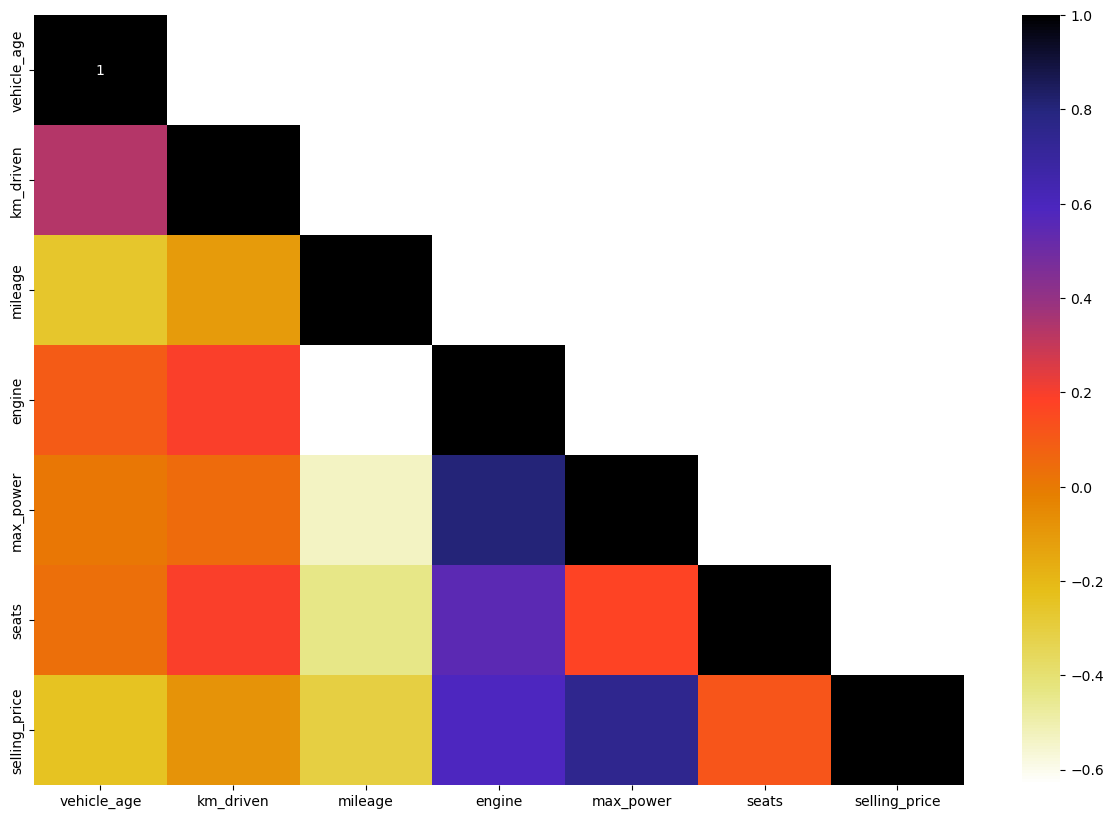

In [31]:
plt.figure(figsize = (15,10))
sns.heatmap(df.corr(numeric_only=True) , cmap="CMRmap_r", annot=True, mask= np.triu(df.corr(numeric_only=True), k=1))
plt.show()

**Report** 
* Max power and Engine cc are highly correlated.
* We can check Vif to remove any highly correlated independent features.

#### Variance Inflation Factor (VIF)

* Multicollinearity occurs when there are two or more independent variables in a multiple regression model, which have a high correlation among themselves. When some features are highly correlated.
* Multicollinearity can be detected using various techniques, one such technique being the Variance Inflation Factor(VIF).

In [35]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
def compute_vif(considered_features, df):
    
    X = df[considered_features]
    # the calculation of variance inflation requires a constant
    X['intercept'] = 1
    
    # create dataframe to store vif values
    vif = pd.DataFrame()
    vif["Variable"] = X.columns
    vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    vif = vif[vif['Variable']!='intercept']
    return vif

In [36]:
compute_vif(num_features, df)

,Variable,VIF
0,vehicle_age,1.406352
1,km_driven,1.212640
2,mileage,1.945103
3,engine,6.244006
4,max_power,5.952622
5,seats,2.245733
6,selling_price,2.680638


 ” VIF determines the strength of the correlation between the independent variables. It is predicted by taking a variable and regressing it against every other variable “ 
 
**- This Dataset Doesnt have any MultiCollinearity**

In [38]:
import statsmodels.api as sm
num_features = df.select_dtypes(exclude="object").columns
for i in range(0, len(num_features)-1):
    x = df.loc[:, df.columns == num_features[i]]
    y = df.selling_price
    model = sm.OLS(x,y)
    results = model.fit()
    rsq = results.rsquared
    vif = round(1 / (1 - rsq), 2)
    print(
        "Variance Inflation Factor of {} column is {} \n".format(
            num_features[i], vif)
        )

Variance Inflation Factor of vehicle_age column is 1.34 

Variance Inflation Factor of km_driven column is 1.24 

Variance Inflation Factor of mileage column is 1.54 

Variance Inflation Factor of engine column is 2.41 

Variance Inflation Factor of max_power column is 3.13 

Variance Inflation Factor of seats column is 1.77 



### Check Outlier and Capping it

**Why outliers?**
* Data Entry error : Human error. 
* Measurement error: Instrument error. 
* Natural error: it will be Real life data.
* Intentional error: People give wrong inputs

**Impact of Outliers ?**
* Ouliers can very high impact on few Machine learning models.
* Can Cause bias in the output.

**Why IQR For Outlier Handling?**
* For Skewed distributions: Use Inter-Quartile Range (IQR) proximity rule.

* The data points which fall below Q1 – 1.5 IQR or above Q3 + 1.5 IQR are outliers.

* where Q1 and Q3 are the 25th and 75th percentile of the dataset respectively, and IQR represents the inter-quartile range and given by Q3 – Q1.

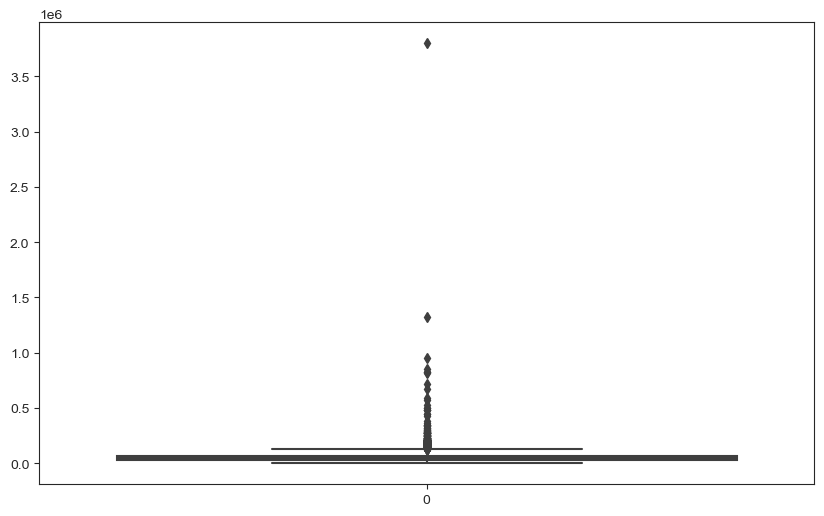

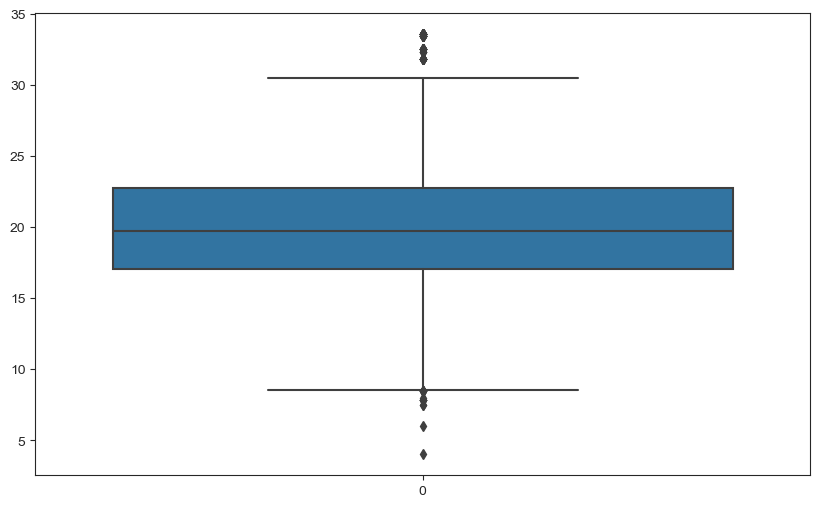

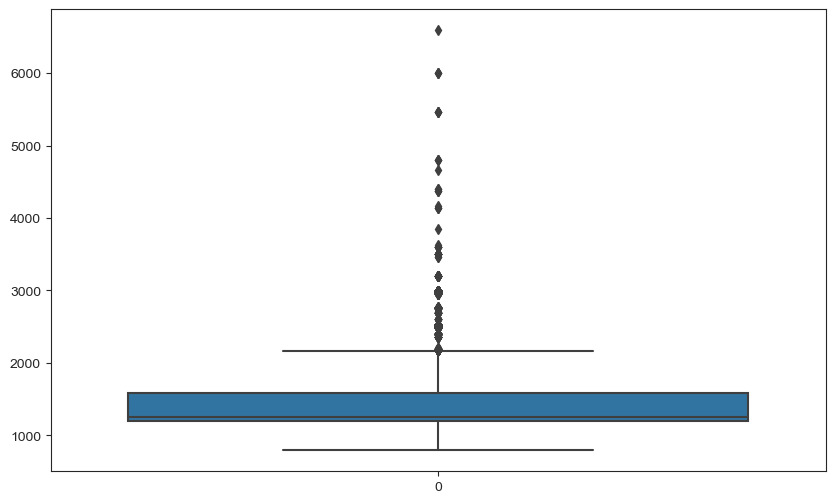

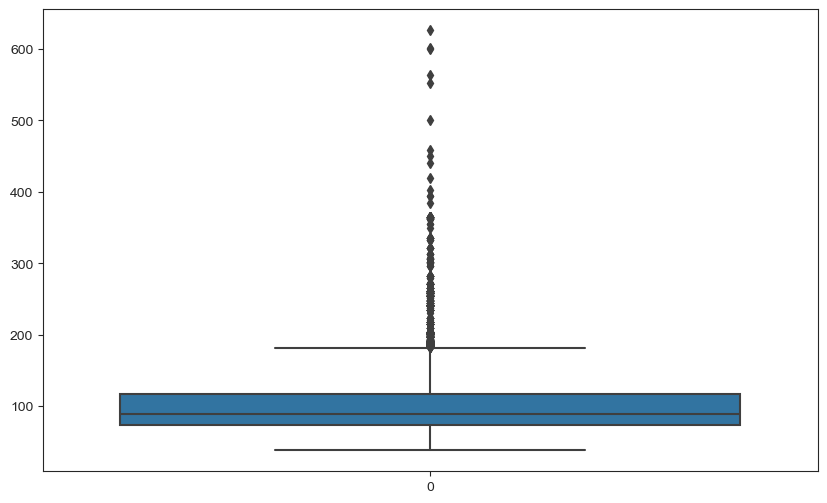

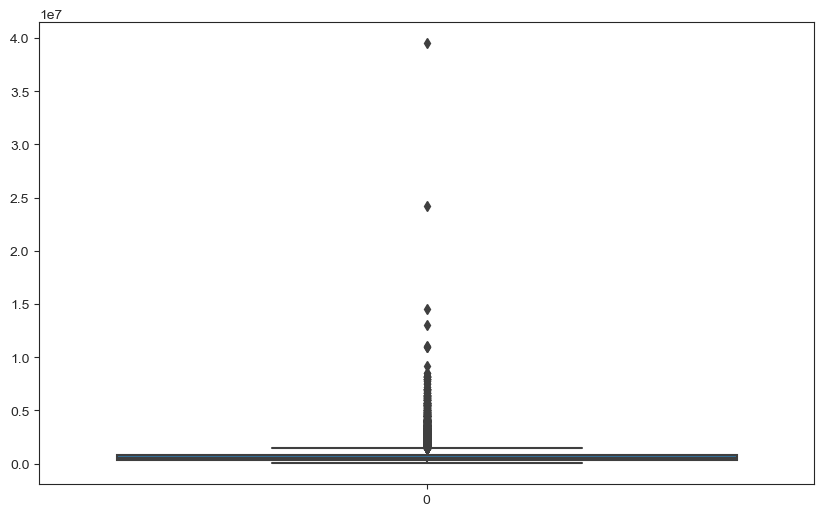

In [42]:
for i in continuous_features:
        plt.figure(figsize=(10,6))
        sns.set_style('ticks')
        ax = sns.boxplot(df[i])

**Detecting Outlier and Capping it**

In [44]:
def detect_outliers(col):
    # Finding the IQR
    percentile25 = df[col].quantile(0.25)
    percentile75 = df[col].quantile(0.75)
    print('\n ####', col , '####')
    print("percentile25",percentile25)
    print("percentile75",percentile75)
    iqr = percentile75 - percentile25
    upper_limit = percentile75 + 1.5 * iqr
    lower_limit = percentile25 - 1.5 * iqr
    print("Upper limit",upper_limit)
    print("Lower limit",lower_limit)
    df.loc[(df[col]>upper_limit), col]= upper_limit
    df.loc[(df[col]<lower_limit), col]= lower_limit    
    return df


# df_capped
# df_trimmed
# df_mvt
# df_unhandled


**Why are we capping it and why not trim it ?**
* Trimming outliers may result in the removal of a large number of records from this dataset as we have already very less rows so this isn’t desirable in this case since columns other than the ones containing the outlier values may contain useful information.

* In this cases, you can use outlier capping to replace the outlier values with a maximum or minimum capped values. Be warned, this manipulates our data but we can replace outlier values by the upper and lower limit calculated using the IQR range.

In [46]:
for col in continuous_features:
         detect_outliers(col)


 #### km_driven ####
percentile25 30000.0
percentile75 70000.0
Upper limit 130000.0
Lower limit -30000.0

 #### mileage ####
percentile25 17.0
percentile75 22.7
Upper limit 31.25
Lower limit 8.450000000000001

 #### engine ####
percentile25 1197.0
percentile75 1582.0
Upper limit 2159.5
Lower limit 619.5

 #### max_power ####
percentile25 74.0
percentile75 117.3
Upper limit 182.25
Lower limit 9.050000000000011

 #### selling_price ####
percentile25 385000.0
percentile75 825000.0
Upper limit 1485000.0
Lower limit -275000.0


**Checking Skewness after Outlier Capping**

In [48]:
df[continuous_features].skew(axis=0, skipna=True)

km_driven        0.617437
mileage          0.067940
engine           0.684096
max_power        1.067229
selling_price    0.968836
dtype: float64

## Feature Transformation

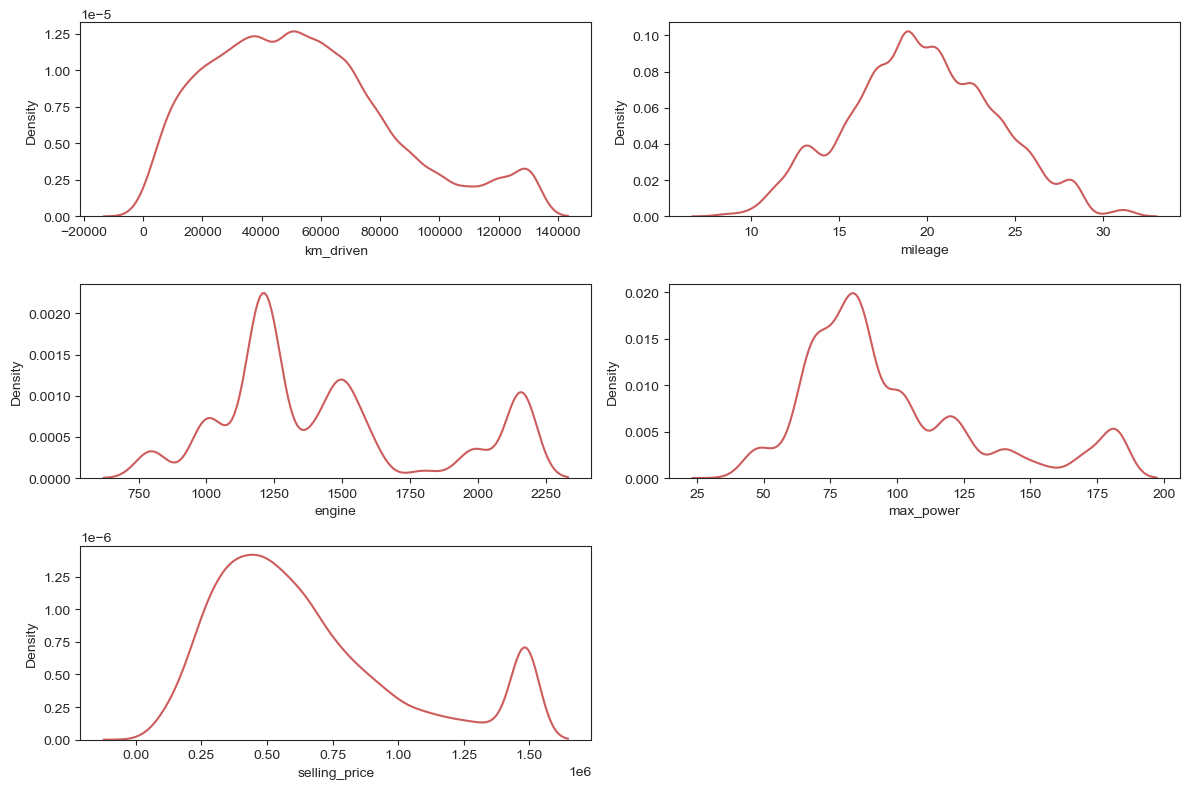

In [50]:
# distribution of data before scaling
plt.figure(figsize=(12, 8))
for i, col in enumerate(['km_driven', 'mileage', 'engine', 'max_power', 'selling_price']):
    plt.subplot(3, 2, i+1)
    sns.kdeplot(x=df[col], color='indianred')
    plt.xlabel(col)
    plt.tight_layout()

* After Capping Outlier it is all column's distribution is Normal so transformation is not required.

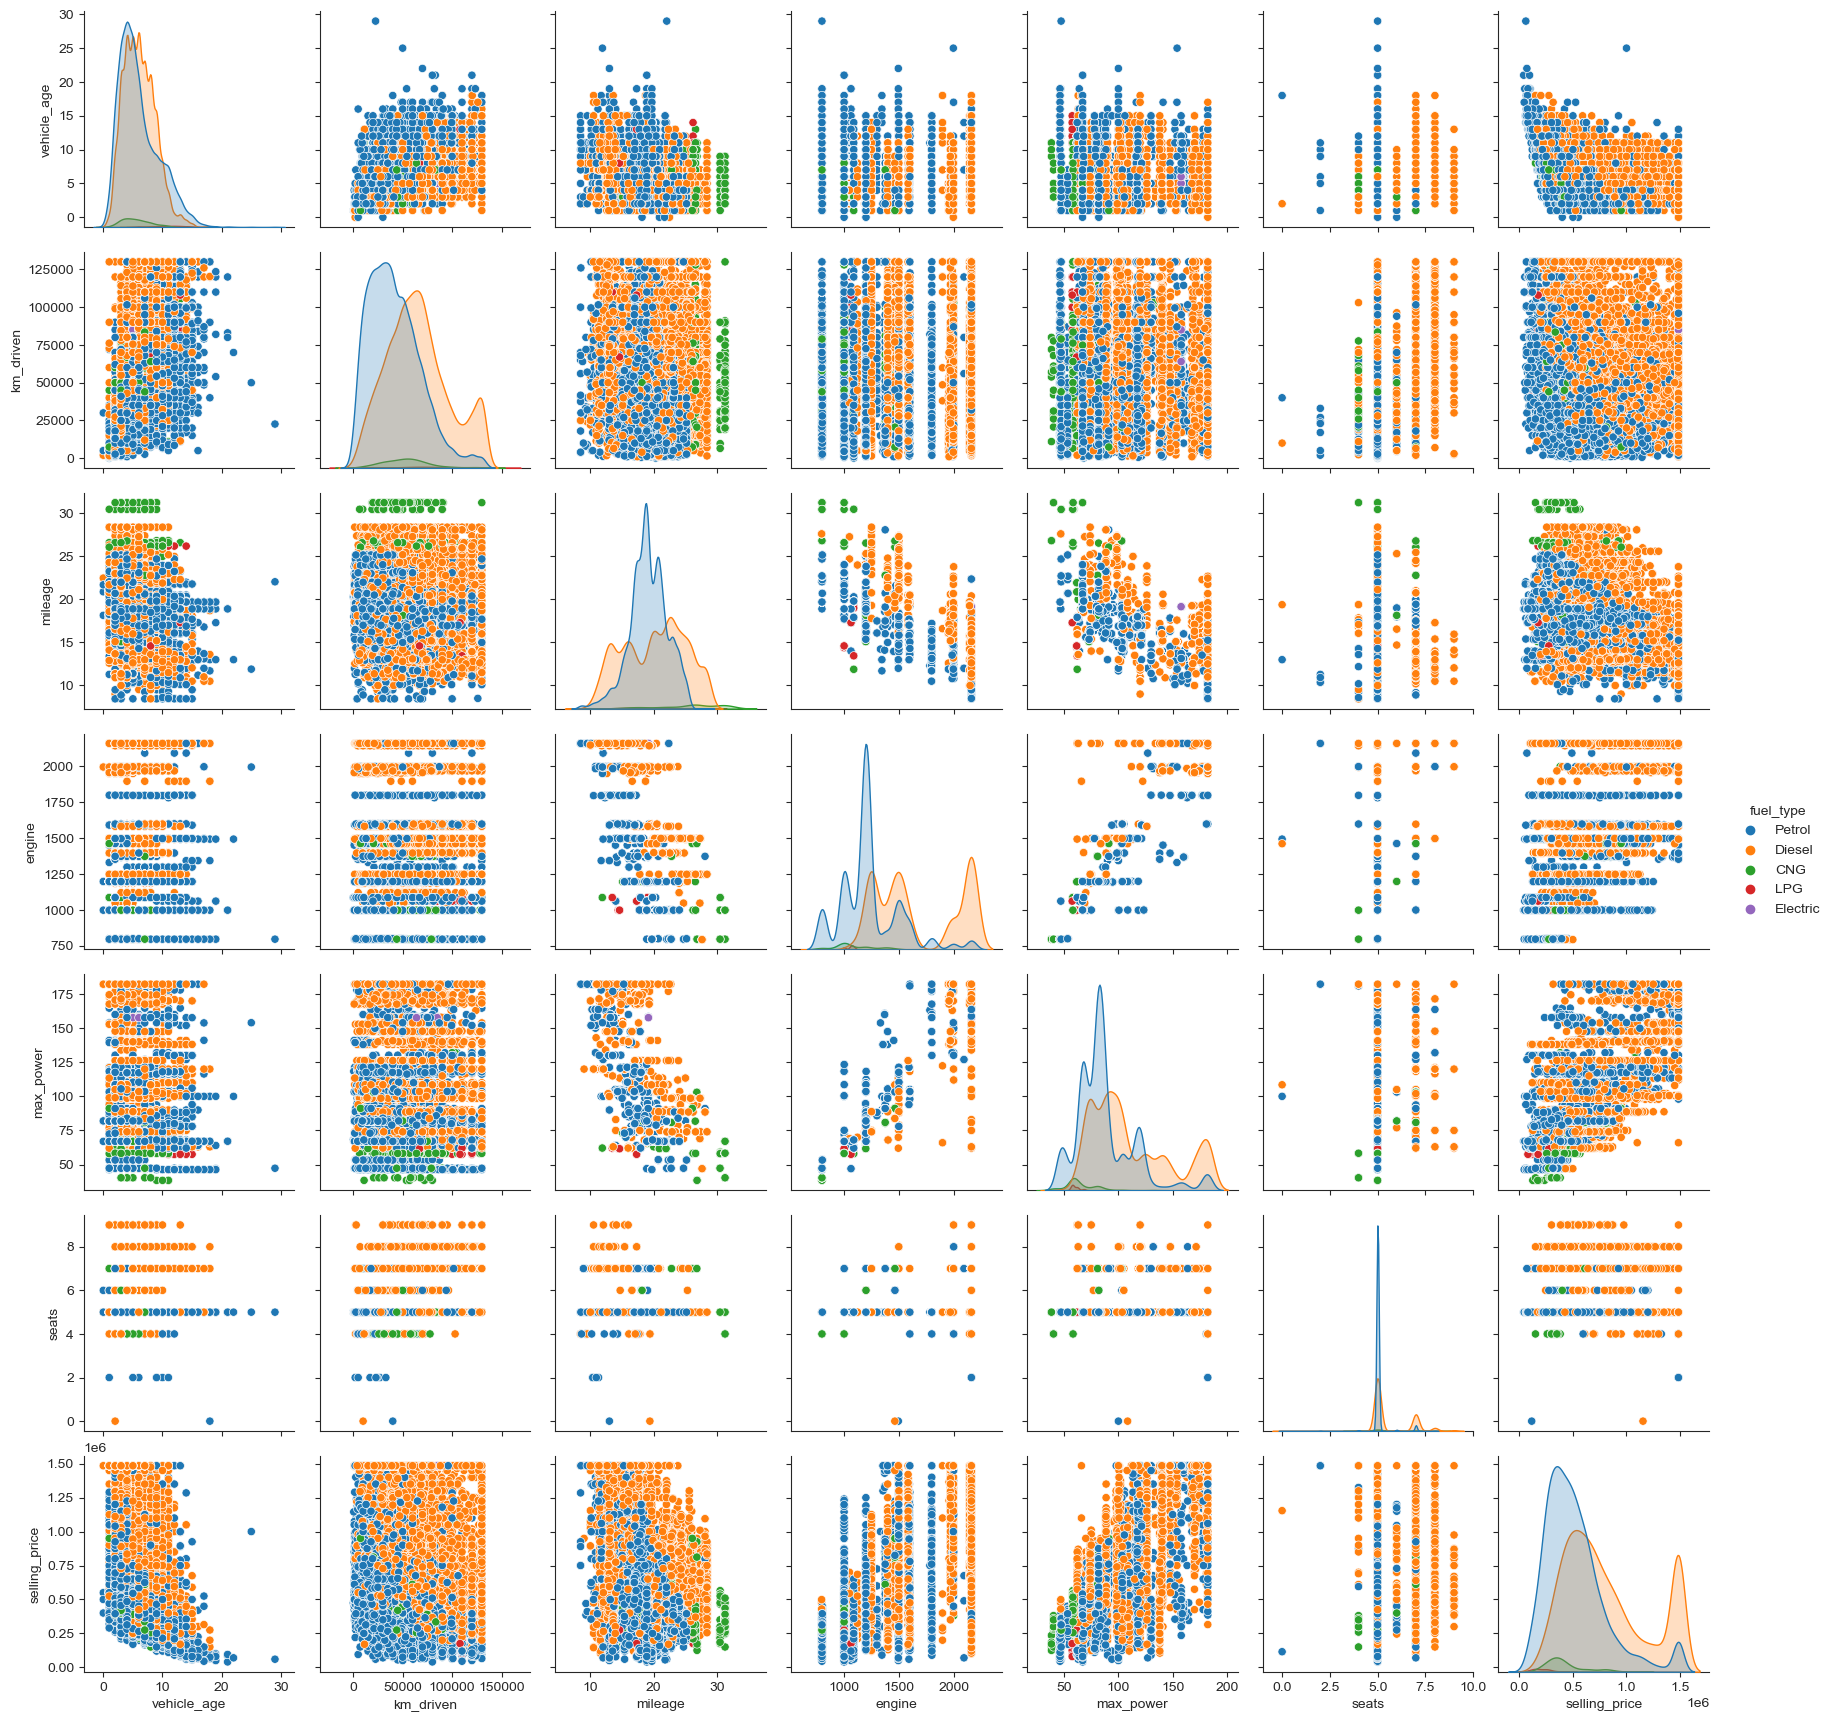

In [52]:
sns.pairplot(data=df,hue='fuel_type')

### Split X and Y

In [54]:
from sklearn.model_selection import train_test_split
X = df.drop(['selling_price'], axis=1)
y = df['selling_price']

* **Split Dataframe to X and y**
* **Here we set a variable X i.e, independent columns, and a variable y i.e, dependent column as the “ProdTaken” column.**


### Feature Selection

In [57]:
for feature in cat_features:
    print(feature,':', X[feature].nunique())

brand : 32
model : 120
seller_type : 3
fuel_type : 5
transmission_type : 2


#### Keeping top and most frequent brands and making less frequency brands as Others

In [59]:
brand= X.brand.value_counts().head(15)
for i in range(df.shape[0]):
    if X['brand'].iloc[i] in brand:
         continue
    else:
        X['brand'].iloc[i] = 'Others'

## Feature Encoding and Scaling

**One Hot Encoding for Columns which had lesser unique values and not ordinal**
* One hot encoding is a process by which categorical variables are converted into a form that could be provided to ML algorithms to do a better job in prediction.

**Binary Encoder**
* To fight the curse of dimensionality, binary encoding might be a good alternative to one-hot encoding because it creates fewer columns when encoding categorical variables.

In [62]:
# Create Column Transformer with 3 types of transformers
num_features = X.select_dtypes(exclude="object").columns
onehot_columns = ['seller_type','fuel_type','transmission_type']
binary_columns = ['brand', 'model']

from sklearn.preprocessing import OneHotEncoder, StandardScaler
from category_encoders.binary import BinaryEncoder
from sklearn.compose import ColumnTransformer

numeric_transformer = StandardScaler()
oh_transformer = OneHotEncoder()
binary_transformer = BinaryEncoder()

preprocessor = ColumnTransformer(
    [
        ("OneHotEncoder", oh_transformer, onehot_columns),
         ("StandardScaler", numeric_transformer, num_features),
        ("BinaryEncoder", binary_transformer, binary_columns)
        
    ]
)

In [63]:
X= preprocessor.fit_transform(X)

## Train Test Split

* The train-test split procedure is used to estimate the performance of machine learning algorithms when they are used to make predictions on data not used to train the model.

* It is a fast and easy procedure to perform, the results of which allow you to compare the performance of machine learning algorithms.

In [66]:
# separate dataset into train and test
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=42)
X_train.shape, X_test.shape

((12328, 28), (3083, 28))

## Model Selection
* **Here should understand the Various Regression models with default values from these models we can choose top 4 with Highest Accuracy score and proceed with HyperParameter Tuning**

**Import Required packages for model training**

In [69]:
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor,AdaBoostRegressor
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression, Ridge,Lasso
from sklearn.metrics import  mean_absolute_error
from sklearn.model_selection import RandomizedSearchCV
from catboost import CatBoostRegressor
from xgboost import XGBRegressor

#### Create a Function to Evaluate Model

In [71]:
def evaluate_model(true, predicted):
    mae = mean_absolute_error(true, predicted)
    mse = mean_squared_error(true, predicted)
    rmse = np.sqrt(mean_squared_error(true, predicted))
    r2_square = r2_score(true, predicted)
    return mae, rmse, r2_square

In [72]:
models = {
    "Linear Regression": LinearRegression(),
    "Lasso": Lasso(),
    "Ridge": Ridge(),
    "K-Neighbors Regressor": KNeighborsRegressor(),
    "Decision Tree": DecisionTreeRegressor(),
    "Random Forest Regressor": RandomForestRegressor(),
    "XGBRegressor": XGBRegressor(), 
    "CatBoosting Regressor": CatBoostRegressor(verbose=False),
    "AdaBoost Regressor": AdaBoostRegressor()
}

for i in range(len(list(models))):
    model = list(models.values())[i]
    model.fit(X_train, y_train) # Train model

    # Make predictions
    y_train_pred = model.predict(X_train) # Overfitting calculation
    y_test_pred = model.predict(X_test)
    
    # Evaluate Train and Test dataset
    model_train_mae , model_train_rmse, model_train_r2 = evaluate_model(y_train, y_train_pred)

    model_test_mae , model_test_rmse, model_test_r2 = evaluate_model(y_test, y_test_pred)

    
    print(list(models.keys())[i])
    
    print('Model performance for Training set')
    print("- Root Mean Squared Error: {:.4f}".format(model_train_rmse))
    print("- Mean Absolute Error: {:.4f}".format(model_train_mae))
    print("- R2 Score: {:.4f}".format(model_train_r2))

    print('----------------------------------')
    
    print('Model performance for Test set')
    print("- Root Mean Squared Error: {:.4f}".format(model_test_rmse))
    print("- Mean Absolute Error: {:.4f}".format(model_test_mae))
    print("- R2 Score: {:.4f}".format(model_test_r2))
    
    print('='*35)
    print('\n')

Linear Regression
Model performance for Training set
- Root Mean Squared Error: 141963.1023
- Mean Absolute Error: 107517.2953
- R2 Score: 0.8525
----------------------------------
Model performance for Test set
- Root Mean Squared Error: 147716.9534
- Mean Absolute Error: 112780.7522
- R2 Score: 0.8505


Lasso
Model performance for Training set
- Root Mean Squared Error: 141937.7122
- Mean Absolute Error: 107498.1354
- R2 Score: 0.8525
----------------------------------
Model performance for Test set
- Root Mean Squared Error: 147728.2550
- Mean Absolute Error: 112790.8417
- R2 Score: 0.8504


Ridge
Model performance for Training set
- Root Mean Squared Error: 141938.8407
- Mean Absolute Error: 107508.7310
- R2 Score: 0.8525
----------------------------------
Model performance for Test set
- Root Mean Squared Error: 147730.9842
- Mean Absolute Error: 112804.6485
- R2 Score: 0.8504


K-Neighbors Regressor
Model performance for Training set
- Root Mean Squared Error: 80173.0849
- Mean A

**Results of All Models**

| Model Name      | R2 Score |
| ----------- | ----------- |
| CatBoost Regressor   | 0.9454        |
|XGBRegressor   | 0.9408        |
| Random Forest | 0.9348       |
| K-Neighbors Regressor   | 0.9303        |
| Gradient Boosting   | 0.9132        |
| Decision Tree Regressor  | 0.9012        |
| AdaBoost Regressor   | 0.8714        |
| Linear Regression   | 0.8505        |
| Ridge Regression   | 0.8504        |
| Lasso Regression   | 0.8504        |

**Here we can use Random Forest , XGBoost Regressor, CatBoost Regressor and K-Neighbours Regressor for Hyper Parameter Tuning**

In [76]:
#Initialize few parameter for Hyperparamter tuning
knn_params = {"n_neighbors": [2, 3, 10, 20, 40, 50]}

rf_params = {"max_depth": [5, 8, 15, None, 10],
             "max_features": [5, 7, "auto", 8],
             "min_samples_split": [2, 8, 15, 20],
             "n_estimators": [100, 200, 500, 1000]}

xgboost_params = {"learning_rate": [0.1, 0.01],
                  "max_depth": [5, 8, 12, 20, 30],
                  "n_estimators": [100, 200, 300],
                  "colsample_bytree": [0.5, 0.8, 1, 0.3, 0.4]}

cat_params = {"learning_rate": [0.1, 0.01, 0.06, 0.05],
              "max_depth": [6, 8, 12, 20, 30]}

In [77]:
# Models list for Hyperparameter tuning
randomcv_models = [('KNN', KNeighborsRegressor(), knn_params),
                   ("RF", RandomForestRegressor(), rf_params),
                   ('XGBoost', XGBRegressor(), xgboost_params),
                   ('CatBoost', CatBoostRegressor(verbose=False), cat_params)
                   ]

In [78]:
from sklearn.model_selection import RandomizedSearchCV

model_param = {}
for name, model, params in randomcv_models:
    random = RandomizedSearchCV(estimator=model,
                                   param_distributions=params,
                                   n_iter=100,
                                   cv=3,
                                   verbose=2,
                                   n_jobs=-1)
    random.fit(X_train, y_train)
    model_param[name] = random.best_params_

for model_name in model_param:
    print(f"---------------- Best Params for {model_name} -------------------")
    print(model_param[model_name])

Fitting 3 folds for each of 6 candidates, totalling 18 fits
[CV] END ......................................n_neighbors=3; total time=   1.0s
[CV] END ......................................n_neighbors=3; total time=   1.1s
[CV] END .....................................n_neighbors=10; total time=   1.1s
[CV] END ......................................n_neighbors=2; total time=   1.0s
[CV] END .....................................n_neighbors=10; total time=   1.1s
[CV] END ......................................n_neighbors=2; total time=   1.1s
[CV] END ......................................n_neighbors=2; total time=   1.1s
[CV] END ......................................n_neighbors=3; total time=   1.2s
[CV] END .....................................n_neighbors=10; total time=   0.3s
[CV] END .....................................n_neighbors=20; total time=   0.3s
[CV] END .....................................n_neighbors=20; total time=   0.3s
[CV] END .....................................n_n

KeyboardInterrupt: 

### Retraining the Model with best Parameters

In [ ]:
models = {
    "Random Forest Regressor": RandomForestRegressor(n_estimators=200, min_samples_split=8, max_features=8, max_depth=15, 
                                                     n_jobs=-1),
     "K-Neighbors Regressor": KNeighborsRegressor(n_neighbors=10, n_jobs=-1),
    "XGBRegressor": XGBRegressor(n_estimators=300, max_depth=5, learning_rate=0.1, colsample_bytree=0.8, n_jobs=-1), 
     "CatBoosting Regressor": CatBoostRegressor(max_depth=8, learning_rate=0.05 ,verbose=False)
}

for i in range(len(list(models))):
    model = list(models.values())[i]
    model.fit(X_train, y_train) # Train model

    # Make predictions
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    model_train_mae , model_train_rmse, model_train_r2 = evaluate_model(y_train, y_train_pred)

    model_test_mae , model_test_rmse, model_test_r2 = evaluate_model(y_test, y_test_pred)
    
    print(list(models.keys())[i])
    
    print('Model performance for Training set')
    print("- Root Mean Squared Error: {:.4f}".format(model_train_rmse))
    print("- Mean Absolute Error: {:.4f}".format(model_train_mae))
    print("- R2 Score: {:.4f}".format(model_train_r2))

    print('----------------------------------')
    
    print('Model performance for Test set')
    print("- Root Mean Squared Error: {:.4f}".format(model_test_rmse))
    print("- Mean Absolute Error: {:.4f}".format(model_test_mae))
    print("- R2 Score: {:.4f}".format(model_test_r2))
    
    print('='*35)
    print('\n')

| Model Name | R2 Score |
| ----------- | ----------- |
| CatBoost Regressor   | 0.9463   |
| XGBRegressor   | 0.9445       |
| RandomForest Regressor | 0.9422      |
| K-Neighbors Regressor   | 0.9299   |

### We can use cross validation score for further evaluation.

Cross-validation is a statistical method used to estimate the accuracy of machine learning models. It is used to protect against overfitting in a predictive model, particularly in a case where the amount of data may be limited.

**Stratified K-fold Cross Validation Technique on 4 algorithm to know the exact Mean CV accuracy score**

In [ ]:
from sklearn.model_selection import cross_val_score, RepeatedKFold
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=42)

In [ ]:
cat_cv_result = cross_val_score(CatBoostRegressor(max_depth=8, learning_rate=0.05 ,verbose=False),
                                X_test, y_test, cv=cv,n_jobs=-1)
cat_cv = cat_cv_result.mean()*100
print('CatBoost CV Mean Accuarcy Score is {}'.format(cat_cv))

In [ ]:
knn_cv_result = cross_val_score(KNeighborsRegressor(n_neighbors=10, n_jobs=-1),
                                X_test, y_test, cv=cv,n_jobs=-1)
knn_cv = knn_cv_result.mean()*100
print('KNN Regressor CV Mean Accuarcy Score is {}'.format(knn_cv))

In [ ]:
rf_cv_result = cross_val_score(RandomForestRegressor(n_estimators=300, min_samples_split=8, max_features=8, max_depth=15, 
                                                     n_jobs=-1), X_test, y_test, cv=cv,n_jobs=-1)
rf_cv = rf_cv_result.mean()*100
print('Random Forest Regressor CV Mean Accuarcy Score is {}'.format(rf_cv))

In [ ]:
xgb_cv_result = cross_val_score(XGBRegressor(n_estimators=300, max_depth=5, learning_rate=0.1, colsample_bytree=0.8, n_jobs=-1),
                                X_test, y_test, cv=cv,n_jobs=-1)
xgb_cv = xgb_cv_result.mean()*100
print('XGB Regressor CV Mean Accuarcy Score is {}'.format(xgb_cv))

| Model Name      | Cross_val_score |
| ----------- | ----------- |
| CatBoosting Regressor   | 93.07%       |
|XGBRegressor   | 92.89%        |
| RandomForest Regressor | 92.55%       |
| K-Neighbors Regressor   | 89.74%        |


In [ ]:
best_model = CatBoostRegressor(max_depth=8, learning_rate=0.05 ,verbose=False)
best_model = best_model.fit(X_train,y_train)
y_pred = best_model.predict(X_test)
score = r2_score(y_test,y_pred)

print("FINAL MODEL 'CatBoost'")
print ("r2 Score value: {:.4f}".format(score))

### Best Model is CATBoost Regressor with 0.9463 R2 Score and also performed well in Cross validation

In [ ]:
import pickle
 
# Save the trained model as a pickle file.
pickle.dump(best_model, open('Usedcarregression.pkl', 'wb'))